# Import librairies

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
from pathlib import Path

import mlflow
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pendulum
import plotly.express as px
import ppscore as pps
import seaborn as sns
from loguru import logger
from mlflow.models import infer_signature
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.datasets import fetch_openml
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import (r2_score,
                             root_mean_squared_error,
                             mean_absolute_percentage_error,
                             mean_absolute_error,
                             max_error,
                            )
from sklearn.model_selection import train_test_split, learning_curve, LearningCurveDisplay
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from ydata_profiling import ProfileReport
from yellowbrick.regressor import PredictionError, ResidualsPlot

sys.path.append(str(Path.cwd().parent))
from settings.params import MODEL_PARAMS, SEED
from src.make_dataset import load_data


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
set_config(display="diagram", print_changed_only=False)  # display sklearn pipeline as diagram

# Settings

In [2]:
# Set logging format
log_fmt = "<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | <cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
logger.configure(handlers=[{"sink": sys.stderr, "format": log_fmt}])

# current data
CURRENT_DATE = pendulum.now(tz="UTC")

# target name definition
TARGET_NAME = MODEL_PARAMS["TARGET_NAME"]
logger.info(f"Target name: {TARGET_NAME}")


# directories
PROJECT_DIR = Path.cwd().parent
REPORTS_DIR = Path(PROJECT_DIR, "reports")

logger.info(f"\nProject directory: {PROJECT_DIR} \nReports dir: {REPORTS_DIR}")

2025-07-31 00:25:38.454 | INFO     | __main__:<module>:10 - Target name: target
2025-07-31 00:25:38.458 | INFO     | __main__:<module>:17 - 
Project directory: c:\Users\DELL\Desktop\mlops-project - Tweets 
Reports dir: c:\Users\DELL\Desktop\mlops-project - Tweets\reports


In [3]:
MODEL_PARAMS

{'TARGET_NAME': 'target',
 'MIN_COMPLETION_RATE': 0.75,
 'MIN_PPS': 0.1,
 'DEFAULT_FEATURE_NAMES': ['Alley',
  'BsmtQual',
  'ExterQual',
  'Foundation',
  'FullBath',
  'GarageArea',
  'GarageCars',
  'GarageFinish',
  'GarageType',
  'GrLivArea',
  'KitchenQualMSSubClass',
  'Neighborhood',
  'OverallQual',
  'TotRmsAbvGrd',
  'building_age',
  'remodel_age',
  'garage_age'],
 'TEST_SIZE': 0.25}

# Data collection

In [4]:
# get data like pandas.DataFrame
data = load_data(dataset_name="tweets")
data.shape

(7613, 5)

In [5]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
data.describe(include="all") #, datetime_is_numeric=True

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


# EDA: Exploratory Data Analysis

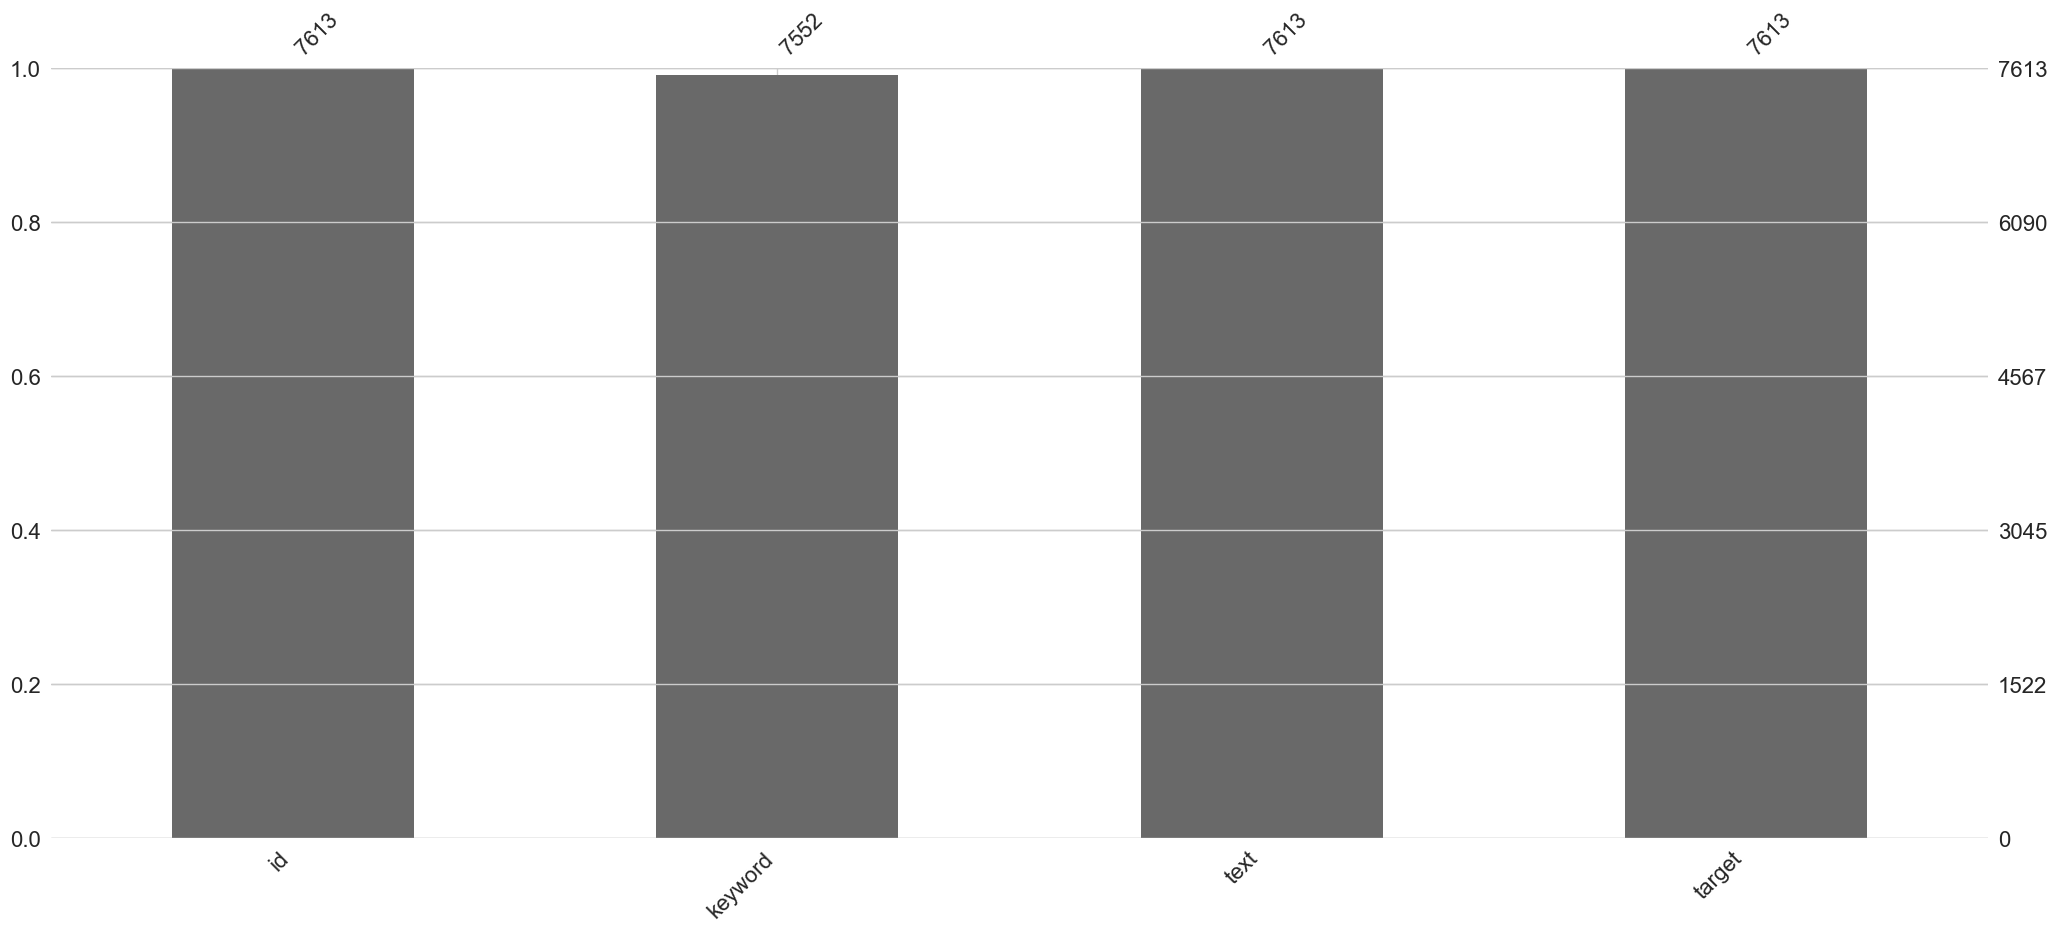

In [8]:
# barplot for missing value rate
msno.bar(data,
         filter="top",
         p=MODEL_PARAMS["MIN_COMPLETION_RATE"],
        );

## Target analysis

In [9]:
MODEL_PARAMS["TARGET_NAME"]

'target'

### Distribution des classes

In [10]:
target_counts = data[TARGET_NAME].value_counts()
target_pct = data[TARGET_NAME].value_counts(normalize=True) * 100

print(f"Distribution des classes:")
print(f"  Classe 0 (Non-Disaster): {target_counts[0]} ({target_pct[0]:.1f}%)")
print(f"  Classe 1 (Disaster): {target_counts[1]} ({target_pct[1]:.1f}%)")

Distribution des classes:
  Classe 0 (Non-Disaster): 4342 (57.0%)
  Classe 1 (Disaster): 3271 (43.0%)


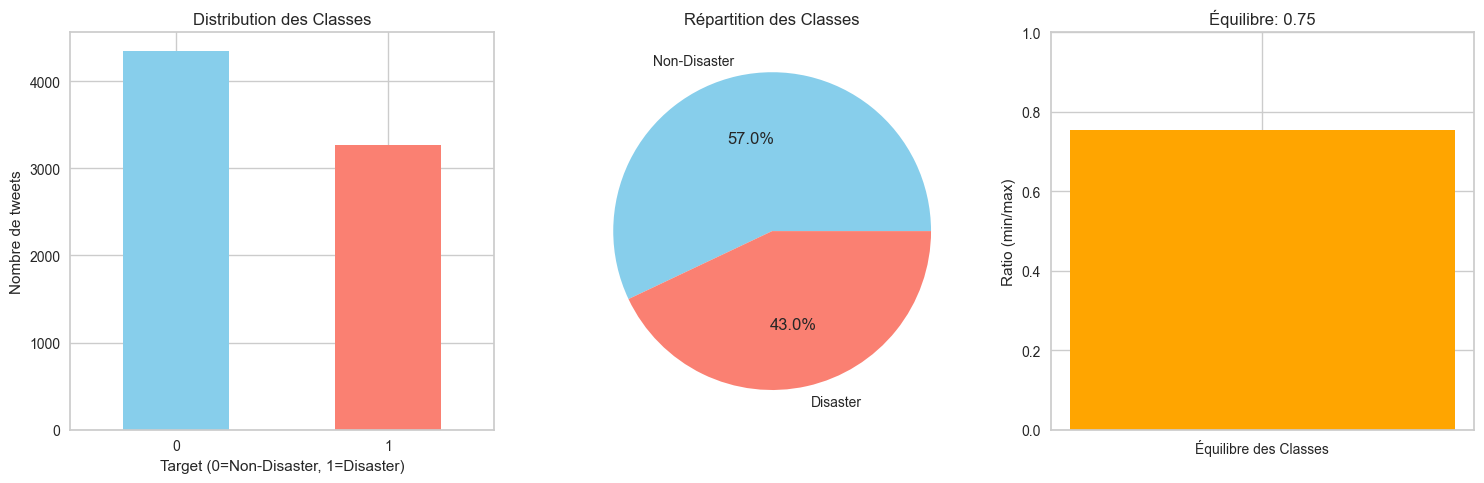

In [11]:
# Visualisation de la distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Graphique en barres
target_counts.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Distribution des Classes')
axes[0].set_xlabel('Target (0=Non-Disaster, 1=Disaster)')
axes[0].set_ylabel('Nombre de tweets')
axes[0].tick_params(axis='x', rotation=0)

# Graphique en secteurs
axes[1].pie(target_counts.values, labels=['Non-Disaster', 'Disaster'], 
           autopct='%1.1f%%', colors=['skyblue', 'salmon'])
axes[1].set_title('Répartition des Classes')

# Graphique d'équilibre
class_balance = min(target_counts) / max(target_counts)
axes[2].bar(['Équilibre des Classes'], [class_balance], color='orange')
axes[2].set_title(f'Équilibre: {class_balance:.2f}')
axes[2].set_ylabel('Ratio (min/max)')
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Analyse des features catégorielles

In [12]:
print("\n📊 4. ANALYSE DES FEATURES CATÉGORIELLES")
print("-" * 50)

# Analyse des keywords
print("🔑 ANALYSE DES KEYWORDS:")
keyword_counts = data['keyword'].value_counts(dropna=False).head(15)
print(f"Top 15 keywords les plus fréquents:")
print(keyword_counts)

# Keywords par classe
keyword_disaster = data[data['target'] == 1]['keyword'].value_counts(dropna=False).head(10)
keyword_normal = data[data['target'] == 0]['keyword'].value_counts(dropna=False).head(10)

print(f"\nTop 10 keywords - Disaster tweets:")
print(keyword_disaster)
print(f"\nTop 10 keywords - Normal tweets:")
print(keyword_normal)

# Analyse des locations
print("\n📍 ANALYSE DES LOCATIONS:")
location_counts = data['location'].value_counts(dropna=False).head(15)
print(f"Top 15 locations les plus fréquentes:")
print(location_counts)


📊 4. ANALYSE DES FEATURES CATÉGORIELLES
--------------------------------------------------
🔑 ANALYSE DES KEYWORDS:
Top 15 keywords les plus fréquents:
keyword
NaN            61
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
evacuate       40
fear           40
outbreak       40
siren          40
twister        40
windstorm      40
collided       40
Name: count, dtype: int64

Top 10 keywords - Disaster tweets:
keyword
NaN                  42
wreckage             39
outbreak             39
derailment           39
typhoon              37
debris               37
oil%20spill          37
rescuers             32
suicide%20bombing    32
suicide%20bomb       32
Name: count, dtype: int64

Top 10 keywords - Normal tweets:
keyword
body%20bags    40
harm           37
armageddon     37
deluge         36
ruin           36
wrecked        36
twister        35
explode        35
fear           35
siren          35
Name: count,

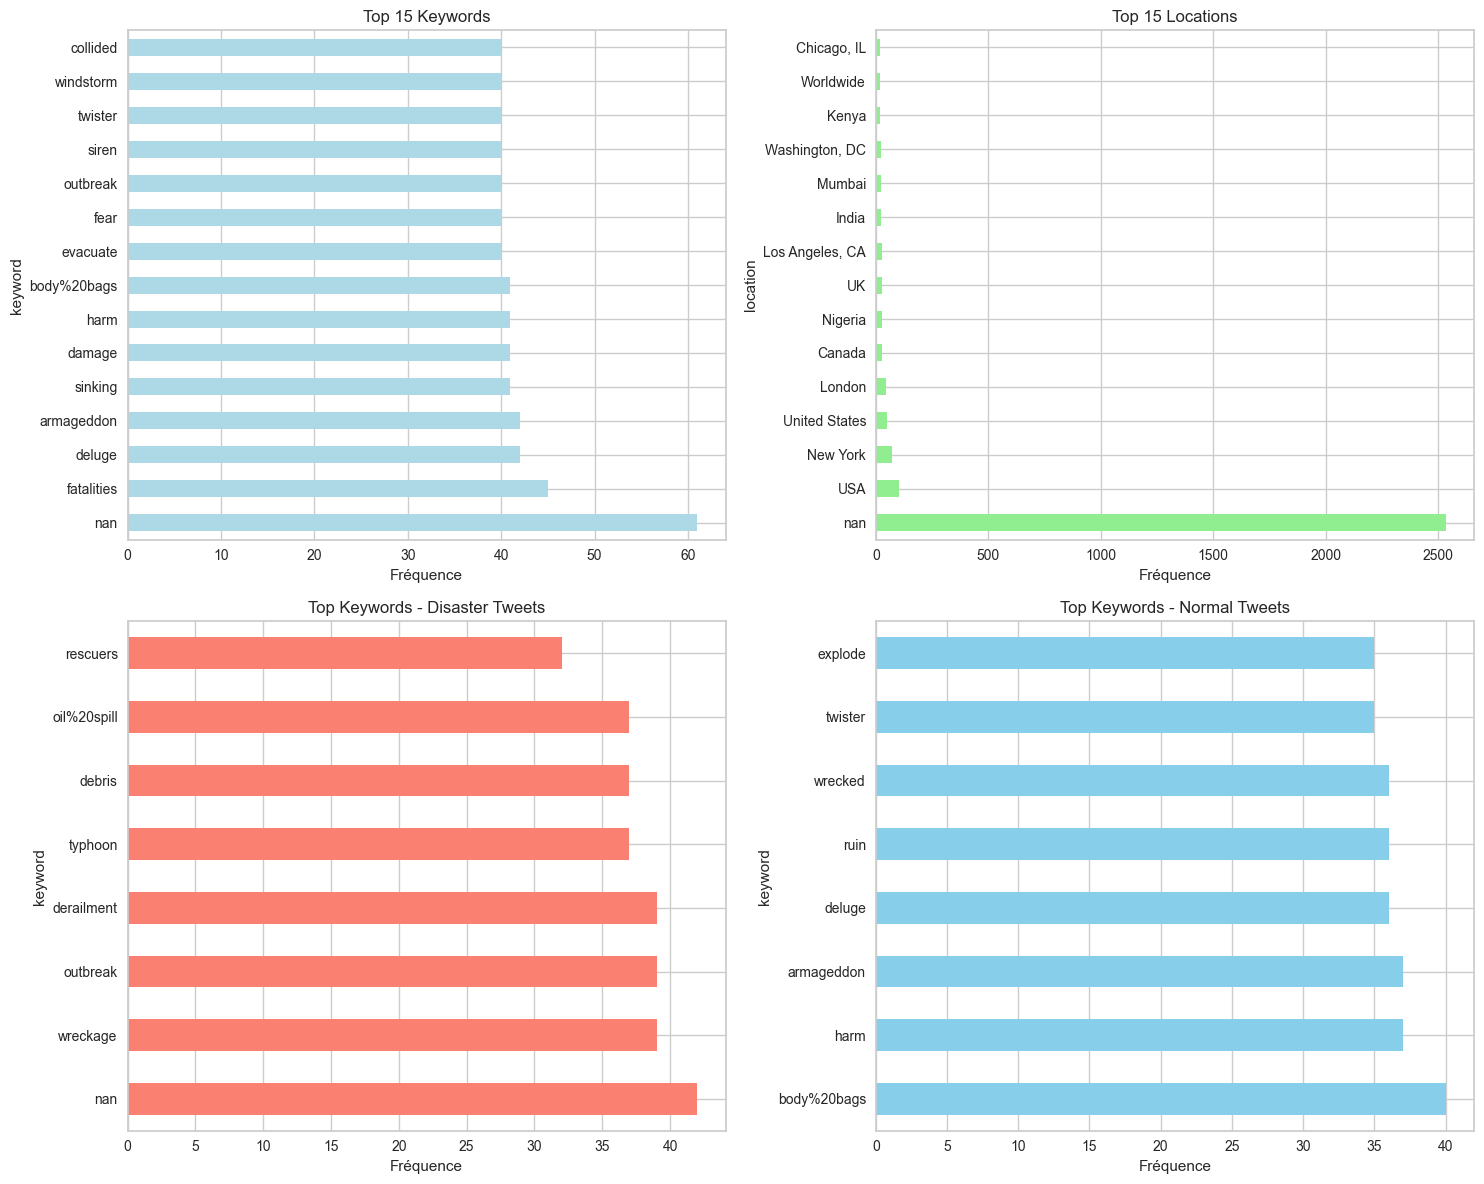

In [13]:
# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Keywords globaux
keyword_counts.plot(kind='barh', ax=axes[0,0], color='lightblue')
axes[0,0].set_title('Top 15 Keywords')
axes[0,0].set_xlabel('Fréquence')

# Locations globales
location_counts.plot(kind='barh', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Top 15 Locations')
axes[0,1].set_xlabel('Fréquence')

# Keywords par classe
keyword_disaster.head(8).plot(kind='barh', ax=axes[1,0], color='salmon')
axes[1,0].set_title('Top Keywords - Disaster Tweets')
axes[1,0].set_xlabel('Fréquence')

keyword_normal.head(8).plot(kind='barh', ax=axes[1,1], color='skyblue')
axes[1,1].set_title('Top Keywords - Normal Tweets')
axes[1,1].set_xlabel('Fréquence')

plt.tight_layout()
plt.show()

### Analyse de texte approfondie

In [14]:
print("\n📊 5. ANALYSE APPROFONDIE DU TEXTE")
print("-" * 50)

# Longueur des textes
data['text_length'] = data['text'].str.len()
data['word_count'] = data['text'].str.split().str.len()

print("📏 STATISTIQUES DE LONGUEUR:")
length_stats = data.groupby('target')[['text_length', 'word_count']].describe()
print(length_stats)

# Caractères spéciaux
data['url_count'] = data['text'].str.count(r'http\S+|www\S+')
data['mention_count'] = data['text'].str.count(r'@\w+')
data['hashtag_count'] = data['text'].str.count(r'#\w+')
data['exclamation_count'] = data['text'].str.count(r'!')
data['question_count'] = data['text'].str.count(r'\?')
data['caps_count'] = data['text'].str.count(r'[A-Z]')

print("\n🔍 CARACTÈRES SPÉCIAUX par classe:")
special_chars = ['url_count', 'mention_count', 'hashtag_count', 'exclamation_count', 'question_count', 'caps_count']
special_stats = data.groupby('target')[special_chars].mean()
print(special_stats)


📊 5. ANALYSE APPROFONDIE DU TEXTE
--------------------------------------------------
📏 STATISTIQUES DE LONGUEUR:
       text_length                                                          \
             count        mean        std   min   25%    50%    75%    max   
target                                                                       
0           4342.0   95.706817  35.885924   7.0  68.0  101.0  130.0  157.0   
1           3271.0  108.113421  29.309854  14.0  88.0  115.0  136.0  151.0   

       word_count                                                    
            count       mean       std  min   25%   50%   75%   max  
target                                                               
0          4342.0  14.704744  6.161564  1.0  10.0  15.0  19.0  31.0  
1          3271.0  15.167533  5.096806  2.0  11.0  15.0  19.0  30.0  

🔍 CARACTÈRES SPÉCIAUX par classe:
        url_count  mention_count  hashtag_count  exclamation_count  \
target                                  

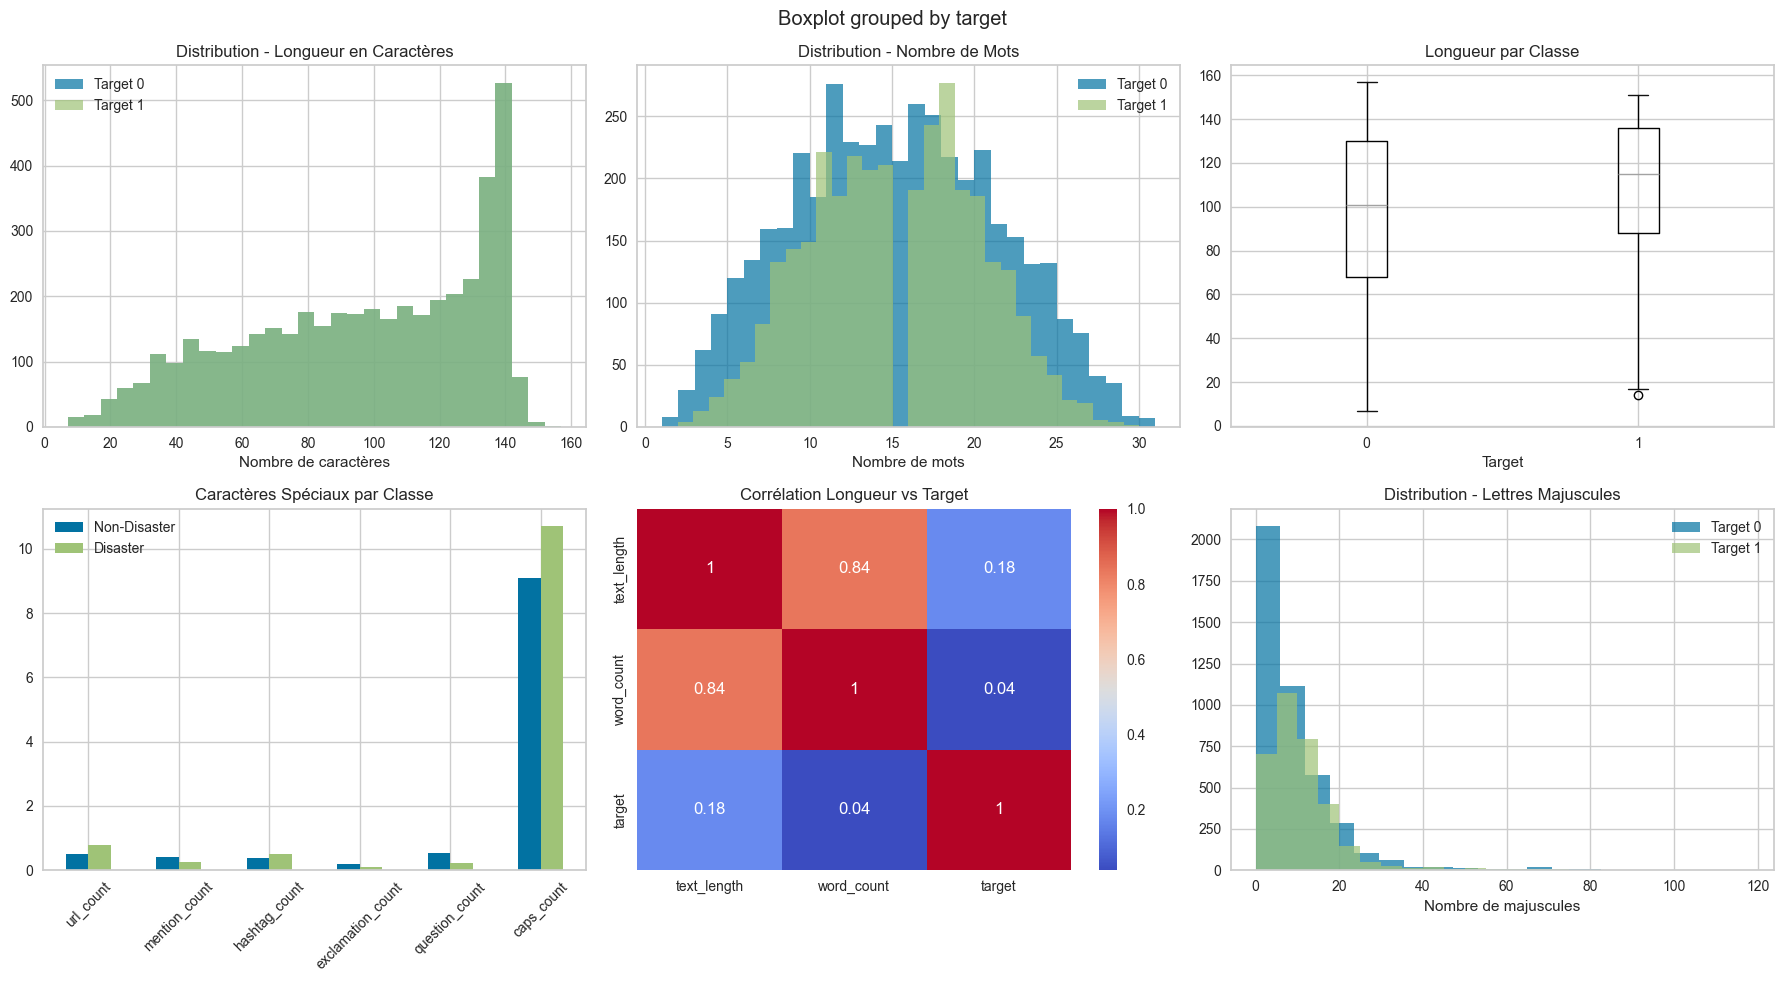

In [15]:
# Visualisation des longueurs
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Distribution longueur caractères
for i, target in enumerate([0, 1]):
    df = data[data[TARGET_NAME] == 0]['text_length']
    axes[0, 0].hist(df, bins=30, alpha=0.7, label=f'Target {target}')
axes[0, 0].set_title('Distribution - Longueur en Caractères')
axes[0, 0].set_xlabel('Nombre de caractères')
axes[0, 0].legend()

# Distribution nombre de mots
for i, target in enumerate([0, 1]):
    df = data[data[TARGET_NAME] == target]['word_count']
    axes[0, 1].hist(df, bins=30, alpha=0.7, label=f'Target {target}')
axes[0, 1].set_title('Distribution - Nombre de Mots')
axes[0, 1].set_xlabel('Nombre de mots')
axes[0, 1].legend()

# Boxplot longueurs par classe
data.boxplot(column='text_length', by='target', ax=axes[0, 2])
axes[0, 2].set_title('Longueur par Classe')
axes[0, 2].set_xlabel('Target')

# Caractères spéciaux
special_stats.T.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Caractères Spéciaux par Classe')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(['Non-Disaster', 'Disaster'])

# Corrélation longueur vs target
correlation_length = data[['text_length', 'word_count', 'target']].corr()
sns.heatmap(correlation_length, annot=True, ax=axes[1, 1], cmap='coolwarm')
axes[1, 1].set_title('Corrélation Longueur vs Target')

# Distribution caps par classe
for i, target in enumerate([0, 1]):
    df = data[data[TARGET_NAME] == target]['caps_count']
    axes[1, 2].hist(df, bins=20, alpha=0.7, label=f'Target {target}')
axes[1, 2].set_title('Distribution - Lettres Majuscules')
axes[1, 2].set_xlabel('Nombre de majuscules')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

In [16]:
## Télécharger NLTK
%pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Analyse des mots les plus fréquents


📊 6. ANALYSE DES MOTS LES PLUS FRÉQUENTS
--------------------------------------------------


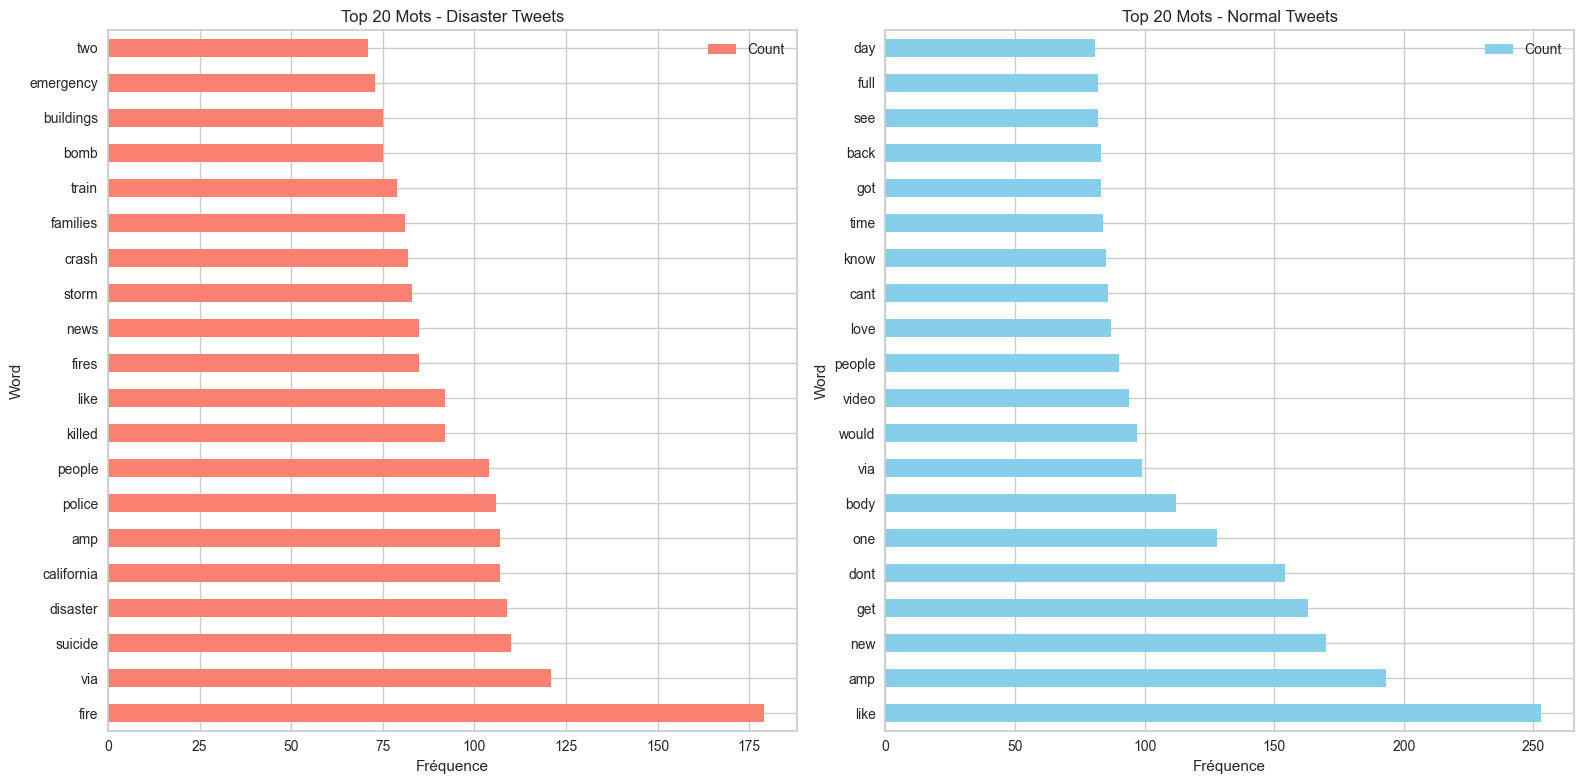

In [17]:
# Pour l'analyse textuelle
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud

print("\n📊 6. ANALYSE DES MOTS LES PLUS FRÉQUENTS")
print("-" * 50)

def clean_text_for_analysis(text):
    """Nettoyage basique pour l'analyse des mots"""
    if not text or pd.isna(text) or not text.strip():
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)



    return text.strip()

# Préparer les textes
disaster_texts = data[data['target'] == 1]['text'].apply(clean_text_for_analysis)
normal_texts = data[data['target'] == 0]['text'].apply(clean_text_for_analysis)

# Mots les plus fréquents
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

def get_top_words(texts, n=20):
    """Obtenir les mots les plus fréquents"""
    all_words = []
    for text in texts:
        words = text.split()
        words = [word for word in words if word not in stop_words and len(word) > 2]
        all_words.extend(words)
    return Counter(all_words).most_common(n)

disaster_words = get_top_words(disaster_texts)
normal_words = get_top_words(normal_texts)


# Visualisation des mots fréquents
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Disaster words
disaster_df = pd.DataFrame(disaster_words, columns=['Word', 'Count'])
disaster_df.plot(x='Word', y='Count', kind='barh', ax=axes[0], color='salmon')
axes[0].set_title('Top 20 Mots - Disaster Tweets')
axes[0].set_xlabel('Fréquence')

# Normal words
normal_df = pd.DataFrame(normal_words, columns=['Word', 'Count'])
normal_df.plot(x='Word', y='Count', kind='barh', ax=axes[1], color='skyblue')
axes[1].set_title('Top 20 Mots - Normal Tweets')
axes[1].set_xlabel('Fréquence')

plt.tight_layout()
plt.show()


### Word Clouds (Nuages de points)


📊 7. NUAGES DE MOTS
--------------------------------------------------


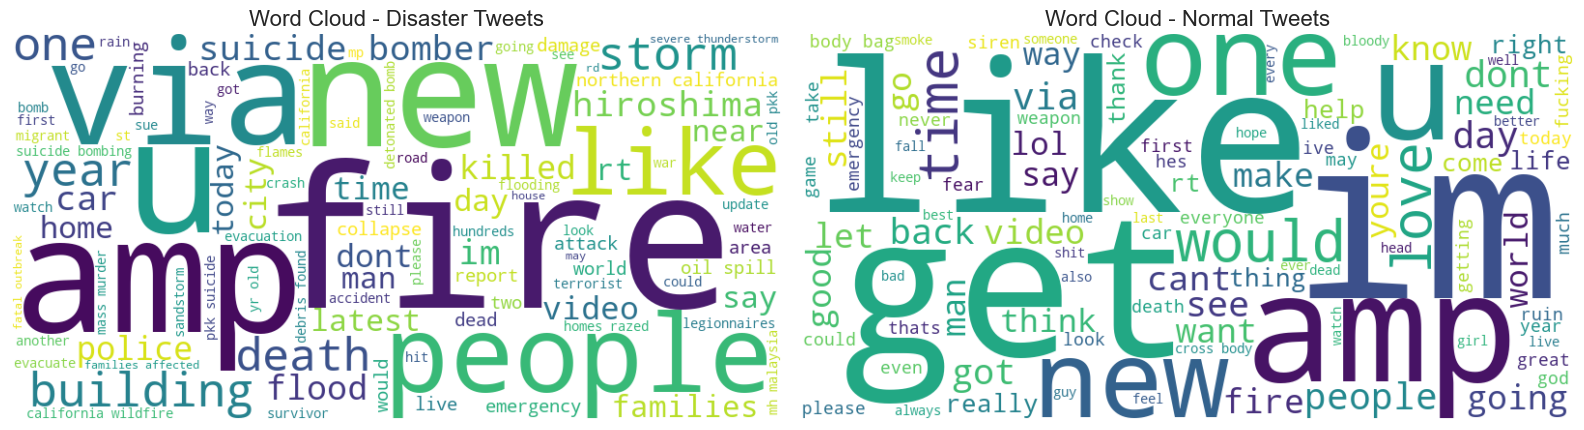

In [18]:

print("\n📊 7. NUAGES DE MOTS")
print("-" * 50)

try:
    # Word cloud pour disaster tweets
    disaster_text_combined = ' '.join(disaster_texts)
    wordcloud_disaster = WordCloud(width=800, height=400, 
                                 background_color='white',
                                 stopwords=stop_words,
                                 max_words=100).generate(disaster_text_combined)

    # Word cloud pour normal tweets
    normal_text_combined = ' '.join(normal_texts)
    wordcloud_normal = WordCloud(width=800, height=400, 
                               background_color='white',
                               stopwords=stop_words,
                               max_words=100).generate(normal_text_combined)

    # Affichage
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].imshow(wordcloud_disaster, interpolation='bilinear')
    axes[0].set_title('Word Cloud - Disaster Tweets', fontsize=16)
    axes[0].axis('off')

    axes[1].imshow(wordcloud_normal, interpolation='bilinear')
    axes[1].set_title('Word Cloud - Normal Tweets', fontsize=16)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("⚠️  WordCloud non disponible. Installer avec: pip install wordcloud")

### Analyse des corrélations


📊 8. ANALYSE DE CORRÉLATION
--------------------------------------------------
🔗 Corrélations avec la variable target:
target               1.000000
url_count            0.195607
text_length          0.181817
mention_count       -0.102692
question_count      -0.084111
caps_count           0.077535
exclamation_count   -0.074543
hashtag_count        0.051633
word_count           0.039966
Name: target, dtype: float64


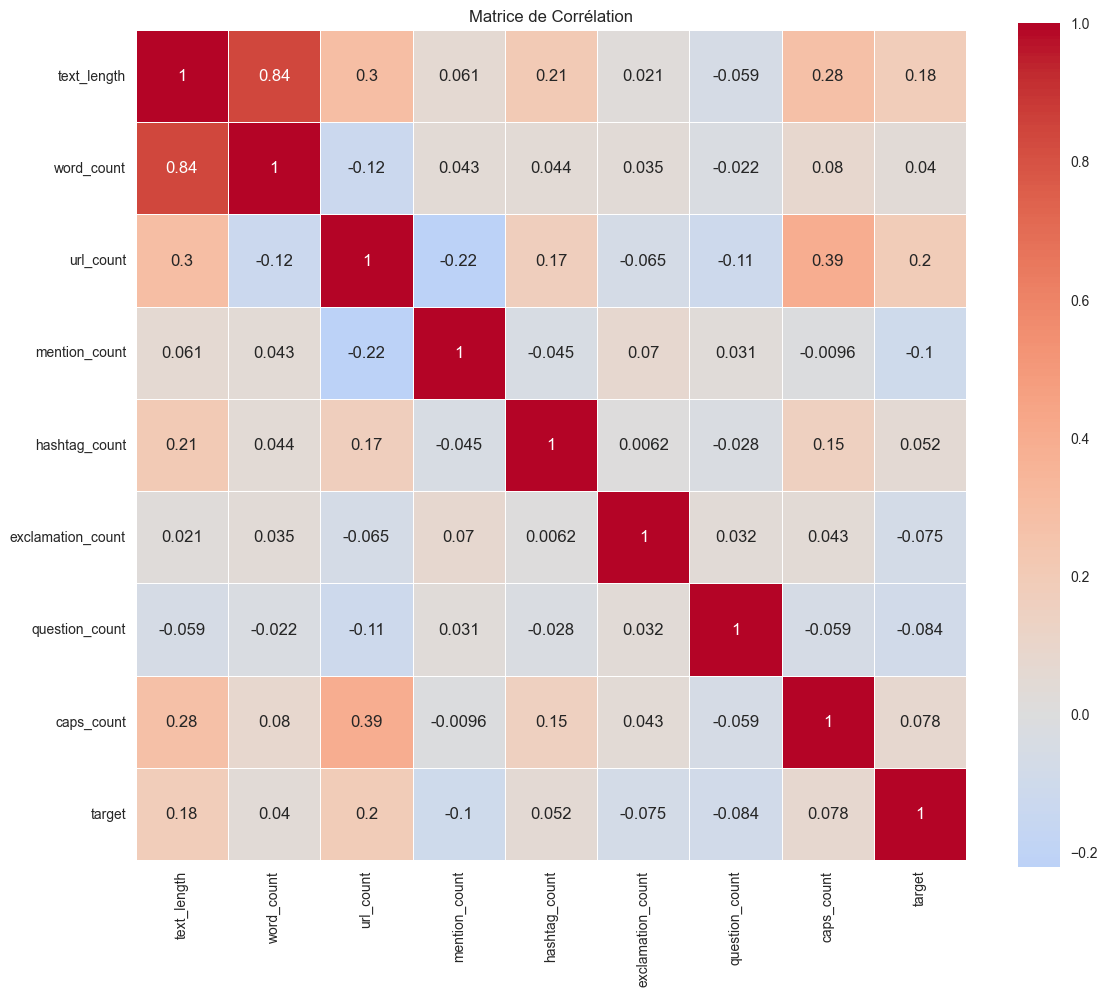

In [19]:
print("\n📊 8. ANALYSE DE CORRÉLATION")
print("-" * 50)

# Matrice de corrélation pour les variables numériques
numeric_features = ['text_length', 'word_count', 'url_count', 'mention_count', 
                   'hashtag_count', 'exclamation_count', 'question_count', 'caps_count', 'target']

correlation_matrix = data[numeric_features].corr()

print("🔗 Corrélations avec la variable target:")
target_correlations = correlation_matrix['target'].sort_values(key=abs, ascending=False)
print(target_correlations)

# Heatmap de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.tight_layout()
plt.show()

## Prétraitement

#### IMPORTS COMPLETS

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
import xgboost as xgb
import lightgbm as lgb

# Pour Word2Vec et FastText
from gensim.models import Word2Vec, FastText
from nltk.tokenize import word_tokenize
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

import re
from scipy.sparse import hstack, csr_matrix
import warnings
warnings.filterwarnings('ignore')

#### PREPROCESSING COMPLET

In [21]:

def extract_features(df):
    """Extrait TOUTES les features importantes selon votre analyse"""
    features = df.copy()
    
    # Top features (dans l'ordre de corrélation)
    features['url_count'] = df['text'].str.count(r'http\S+|www\S+')           # +0.196
    features['text_length'] = df['text'].str.len()                            # +0.182
    features['mention_count'] = df['text'].str.count(r'@\w+')                 # -0.103
    features['question_count'] = df['text'].str.count(r'\?')                  # -0.084
    features['caps_count'] = df['text'].str.count(r'[A-Z]')                   # +0.078
    features['exclamation_count'] = df['text'].str.count(r'!')                # -0.075
    features['hashtag_count'] = df['text'].str.count(r'#\w+')                 # +0.052
    features['word_count'] = df['text'].str.split().str.len()                 # +0.040
    
    # Features composées
    features['urgency_score'] = features['url_count'] + features['caps_count']
    features['social_score'] = features['mention_count'] + features['hashtag_count']
    
    return features

def clean_text(text):
    """Nettoyage intelligent du texte"""
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return ' '.join(text.split())

def preprocess_data(df):
    """Preprocessing complet - remplace votre classe"""
    print("🔧 Preprocessing complet...")
    
    # Features numériques
    df_features = extract_features(df)
    
    # Nettoyage du texte
    df_features['clean_text'] = df['text'].apply(clean_text)
    
    # Encodage des catégories
    le_location = LabelEncoder()
    le_keyword = LabelEncoder()
    
    df_features['location_encoded'] = le_location.fit_transform(df['location'].fillna('unknown'))
    df_features['keyword_encoded'] = le_keyword.fit_transform(df['keyword'].fillna('none'))
    
    return df_features, le_location, le_keyword

print(extract_features(data).columns)

Index(['id', 'keyword', 'location', 'text', 'target', 'text_length',
       'word_count', 'url_count', 'mention_count', 'hashtag_count',
       'exclamation_count', 'question_count', 'caps_count', 'urgency_score',
       'social_score'],
      dtype='object')


#### TOUS LES VECTORIZERS 

In [22]:
def get_tfidf_features(X_train, X_test, max_features=5000):
    """TF-IDF Vectorization"""
    print("  📝 TF-IDF...")
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(1,2))
    X_train_vec = tfidf.fit_transform(X_train['clean_text'])
    X_test_vec = tfidf.transform(X_test['clean_text'])
    return X_train_vec, X_test_vec, tfidf

def get_word2vec_features(X_train, X_test, vector_size=100):
    """Word2Vec Vectorization"""
    print("  🧠 Word2Vec...")
    
    # Tokenisation
    train_tokens = [text.split() for text in X_train['clean_text']]
    test_tokens = [text.split() for text in X_test['clean_text']]
    
    # Entraînement Word2Vec
    w2v_model = Word2Vec(sentences=train_tokens, vector_size=vector_size, window=5, min_count=2, workers=4)
    
    # Moyenne des vecteurs par document
    def average_vectors(tokens, model):
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)
    
    X_train_vec = np.array([average_vectors(tokens, w2v_model) for tokens in train_tokens])
    X_test_vec = np.array([average_vectors(tokens, w2v_model) for tokens in test_tokens])
    
    return csr_matrix(X_train_vec), csr_matrix(X_test_vec), w2v_model

def get_fasttext_features(X_train, X_test, vector_size=100):
    """FastText Vectorization"""
    print("  ⚡ FastText...")
    
    # Tokenisation
    train_tokens = [text.split() for text in X_train['clean_text']]
    test_tokens = [text.split() for text in X_test['clean_text']]
    
    # Entraînement FastText
    ft_model = FastText(sentences=train_tokens, vector_size=vector_size, window=5, min_count=2, workers=4)
    
    # Moyenne des vecteurs par document
    def average_vectors(tokens, model):
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)
    
    X_train_vec = np.array([average_vectors(tokens, ft_model) for tokens in train_tokens])
    X_test_vec = np.array([average_vectors(tokens, ft_model) for tokens in test_tokens])
    
    return csr_matrix(X_train_vec), csr_matrix(X_test_vec), ft_model

#### MODÈLES À TESTER

In [23]:
models_config = {
    'Logistic': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
}

vectorizers_config = {
    'TF-IDF': get_tfidf_features,
    'Word2Vec': get_word2vec_features,
    'FastText': get_fasttext_features
}

#### TEST TOUTES COMBINAISONS

In [24]:
def test_all_combinations(X_train, X_test, y_train, y_test):
    """Test TOUTES les combinaisons modèle + vectorizer"""
    
    print("🚀 TEST DE TOUTES LES COMBINAISONS")
    print("=" * 50)
    
    # Features numériques (communes à tous)
    num_features = ['url_count', 'text_length', 'mention_count', 'question_count',
                   'caps_count', 'exclamation_count', 'hashtag_count', 'word_count',
                   'urgency_score', 'social_score', 'location_encoded', 'keyword_encoded']
    
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train[num_features])
    X_test_num = scaler.transform(X_test[num_features])
    
    results = []
    
    # Boucle sur tous les vectorizers
    for vec_name, vec_func in vectorizers_config.items():
        print(f"\n📊 VECTORIZER: {vec_name}")
        print("-" * 25)
        
        try:
            # Obtenir les features textuelles
            X_train_text, X_test_text, vectorizer = vec_func(X_train, X_test)
            
            # Combiner avec les features numériques
            X_train_final = hstack([X_train_text, csr_matrix(X_train_num)])
            X_test_final = hstack([X_test_text, csr_matrix(X_test_num)])
            
            # Tester tous les modèles avec ce vectorizer
            for model_name, model in models_config.items():
                print(f"  🎯 {model_name}...", end=" ")
                
                try:
                    # Entraînement
                    model.fit(X_train_final, y_train)
                    
                    # Prédictions
                    y_pred = model.predict(X_test_final)
                    
                    # Métriques
                    f1 = f1_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    
                    # Cross-validation
                    cv_scores = cross_val_score(model, X_train_final, y_train, cv=3, scoring='f1')
                    cv_mean = cv_scores.mean()
                    cv_std = cv_scores.std()
                    
                    results.append({
                        'Vectorizer': vec_name,
                        'Model': model_name,
                        'F1_Test': f1,
                        'Accuracy_Test': accuracy,
                        'F1_CV_Mean': cv_mean,
                        'F1_CV_Std': cv_std,
                        'Combination': f"{vec_name} + {model_name}"
                    })
                    
                    print(f"F1: {f1:.4f} | CV: {cv_mean:.4f}±{cv_std:.4f}")
                    
                except Exception as e:
                    print(f"❌ Erreur: {str(e)}")
            
        except Exception as e:
            print(f"❌ Erreur avec {vec_name}: {str(e)}")
    
    return results




#### Analyse des résultats

In [25]:
def analyze_results(results):
    """Analyse complète des résultats"""
    
    if not results:
        print("❌ Aucun résultat à analyser")
        return None
    
    df = pd.DataFrame(results)
    df_sorted = df.sort_values('F1_Test', ascending=False)
    
    print("\n🏆 TOP 10 COMBINAISONS")
    print("=" * 50)
    print(df_sorted.head(10)[['Combination', 'F1_Test', 'Accuracy_Test', 'F1_CV_Mean']].to_string(index=False))
    
    print(f"\n🥇 MEILLEURE COMBINAISON:")
    best = df_sorted.iloc[0]
    print(f"   {best['Combination']}")
    print(f"   F1 Test: {best['F1_Test']:.4f}")
    print(f"   Accuracy: {best['Accuracy_Test']:.4f}")
    print(f"   F1 CV: {best['F1_CV_Mean']:.4f} ± {best['F1_CV_Std']:.4f}")
    
    # Analyse par vectorizer
    print(f"\n📈 ANALYSE PAR VECTORIZER:")
    vec_analysis = df.groupby('Vectorizer').agg({
        'F1_Test': ['mean', 'max', 'std'],
        'F1_CV_Mean': 'mean'
    }).round(4)
    print(vec_analysis)
    
    # Analyse par modèle
    print(f"\n🤖 ANALYSE PAR MODÈLE:")
    model_analysis = df.groupby('Model').agg({
        'F1_Test': ['mean', 'max', 'std'],
        'F1_CV_Mean': 'mean'
    }).round(4)
    print(model_analysis)
    
    return df_sorted

#### Quick Start

In [26]:
def quick_start(df, target_col='target'):
    """Démarrage rapide - teste tout automatiquement"""
    
    print("⚡ QUICK START - Test complet automatique")
    print("=" * 50)
    
    # Split des données
    X = df[['text', 'location', 'keyword']]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Preprocessing
    X_train_processed, _, _ = preprocess_data(X_train)
    X_test_processed, _, _ = preprocess_data(X_test)
    
    # Test toutes les combinaisons
    results = test_all_combinations(X_train_processed, X_test_processed, y_train, y_test)
    
    # Analyse
    df_results = analyze_results(results)
    
    return df_results, results 

quick_start(data)

⚡ QUICK START - Test complet automatique
🔧 Preprocessing complet...
🔧 Preprocessing complet...
🚀 TEST DE TOUTES LES COMBINAISONS

📊 VECTORIZER: TF-IDF
-------------------------
  📝 TF-IDF...
  🎯 Logistic... F1: 0.7530 | CV: 0.7277±0.0058
  🎯 RandomForest... F1: 0.6955 | CV: 0.6758±0.0092
  🎯 XGBoost... F1: 0.7221 | CV: 0.7003±0.0086
  🎯 LightGBM... F1: 0.7331 | CV: 0.6987±0.0083

📊 VECTORIZER: Word2Vec
-------------------------
  🧠 Word2Vec...
  🎯 Logistic... F1: 0.6129 | CV: 0.6013±0.0051
  🎯 RandomForest... F1: 0.6411 | CV: 0.6337±0.0058
  🎯 XGBoost... F1: 0.6788 | CV: 0.6549±0.0017
  🎯 LightGBM... F1: 0.6785 | CV: 0.6627±0.0037

📊 VECTORIZER: FastText
-------------------------
  ⚡ FastText...
  🎯 Logistic... F1: 0.5714 | CV: 0.5620±0.0096
  🎯 RandomForest... F1: 0.6468 | CV: 0.6334±0.0072
  🎯 XGBoost... F1: 0.6734 | CV: 0.6503±0.0050
  🎯 LightGBM... F1: 0.6985 | CV: 0.6586±0.0009

🏆 TOP 10 COMBINAISONS
            Combination  F1_Test  Accuracy_Test  F1_CV_Mean
      TF-IDF + Logist

(   Vectorizer         Model   F1_Test  Accuracy_Test  F1_CV_Mean  F1_CV_Std  \
 0      TF-IDF      Logistic  0.753036       0.799737    0.727661   0.005801   
 3      TF-IDF      LightGBM  0.733061       0.785292    0.698744   0.008280   
 2      TF-IDF       XGBoost  0.722130       0.780696    0.700260   0.008590   
 11   FastText      LightGBM  0.698464       0.755089    0.658631   0.000930   
 1      TF-IDF  RandomForest  0.695499       0.773473    0.675841   0.009174   
 6    Word2Vec       XGBoost  0.678826       0.734077    0.654854   0.001731   
 7    Word2Vec      LightGBM  0.678543       0.739330    0.662689   0.003703   
 10   FastText       XGBoost  0.673422       0.724885    0.650295   0.005034   
 9    FastText  RandomForest  0.646816       0.719632    0.633358   0.007223   
 5    Word2Vec  RandomForest  0.641068       0.717663    0.633698   0.005796   
 4    Word2Vec      Logistic  0.612929       0.681550    0.601307   0.005145   
 8    FastText      Logistic  0.571429  

### Best model

#### Prétraitement sur les données (Split données + TF-IDF)

In [27]:
# Étape 1 : split des colonnes utiles
X = data[['text', 'location', 'keyword']]
y = data['target']

from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Étape 2 : preprocessing (déjà défini dans ton code)
X_train_processed, _, _ = preprocess_data(X_train_raw)
X_test_processed, _, _ = preprocess_data(X_test_raw)

# Étape 3 : vectorisation TF-IDF (déjà définie aussi)
X_train_vec, X_test_vec, tfidf = get_tfidf_features(X_train_processed, X_test_processed)


🔧 Preprocessing complet...
🔧 Preprocessing complet...
  📝 TF-IDF...


#### Optimisation : Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 1.5, 2],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

grid_lr.fit(X_train_vec, y_train)
print("Best params LR:", grid_lr.best_params_)
print("Best F1 CV LR:", grid_lr.best_score_)

Best params LR: {'C': 1.5, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 CV LR: 0.7390213038494786


#### Optimisation : XGBoost

In [29]:
import xgboost as xgb

param_grid_xgb = {
    'n_estimators': [700, 800, 600],
    'max_depth': [7, 5, 6],
    'learning_rate': [0.5, 0.3, 0.2]
}

grid_xgb = GridSearchCV(
    xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid_xgb,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

grid_xgb.fit(X_train_vec, y_train)
print("Best params XGB:", grid_xgb.best_params_)
print("Best F1 CV XGB:", grid_xgb.best_score_)

Best params XGB: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 800}
Best F1 CV XGB: 0.715595017305107


#### Optimisation : LightGBM

In [30]:
import lightgbm as lgb

param_grid_lgb = {
    'n_estimators': [600, 400, 200],
    'max_depth': [-1, -3, 1],
    'learning_rate': [0.05, 0.1, 0.2]
}

grid_lgb = GridSearchCV(
    lgb.LGBMClassifier(random_state=42),
    param_grid_lgb,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

grid_lgb.fit(X_train_vec, y_train)
print("Best params LGBM:", grid_lgb.best_params_)
print("Best F1 CV LGBM:", grid_lgb.best_score_)

Best params LGBM: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200}
Best F1 CV LGBM: 0.6870690104510798


#### Évaluation sur test set du meilleur modèle

In [31]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

best_model = grid_lr.best_estimator_
y_pred = best_model.predict(X_test_vec)

print("F1 test:", f1_score(y_test, y_pred))
print("Accuracy test:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

F1 test: 0.7583081570996979
Accuracy test: 0.7898883782009193
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       869
           1       0.75      0.77      0.76       654

    accuracy                           0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523



### Tracking

In [32]:
# Create an experiment if not exists
exp_name = "house-price"
experiment = mlflow.get_experiment_by_name(exp_name)
if not experiment:
    experiment_id = mlflow.create_experiment(exp_name)
else:
    experiment_id = experiment.experiment_id
    
logger.info(f"Experience id: {experiment_id}")

2025-07-31 00:42:34.520 | INFO     | __main__:<module>:9 - Experience id: 731119558035002171


### Save model

In [33]:
## Save vectoriser
import joblib

#joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

In [34]:
## Save model
# Sauvegarde
joblib.dump(best_model, 'best_model.pkl')

# Chargement plus tard
loaded_model = joblib.load('best_model.pkl')

In [35]:
# Étape 1 : tout le dataset
import joblib

X_all = data[['text', 'location', 'keyword']]
y_all = data['target']

# Étape 2 : preprocess complet
X_all_processed, le_location, le_keyword = preprocess_data(X_all)

# Étape 3 : vectorisation
X_all_vec, _, tfidf = get_tfidf_features(X_all_processed, X_all_processed)  # X_test est ignoré ici

# Étape 4 : modèle avec meilleurs hyperparams (ex: logistic regression avec C=1.0)

final_model = LogisticRegression(C=1.5, class_weight='balanced', max_iter=1000, random_state=42, penalty = 'l2', solver= 'lbfgs')

final_model.fit(X_all_vec, y_all)

# Étape 5 : sauvegarde
joblib.dump(final_model, 'model.pkl')
joblib.dump(tfidf, 'tfidf.pkl')
joblib.dump(le_location, 'le_location.pkl')
joblib.dump(le_keyword, 'le_keyword.pkl')


🔧 Preprocessing complet...
  📝 TF-IDF...


['le_keyword.pkl']

In [36]:
import joblib
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
data['clean_text'] = data['text'].apply(clean_text)
X_train_vec = tfidf.fit_transform(data['clean_text'])
joblib.dump(tfidf, 'tfidf.pkl')

['tfidf.pkl']

In [37]:
tfidfer = joblib.load('tfidf.pkl')
tfidfer.transform()

TypeError: TfidfVectorizer.transform() missing 1 required positional argument: 'raw_documents'

In [ ]:
#tfidf.transform()
type(data["clean_text"])

pandas.core.series.Series

In [ ]:
tfidf.transform(data["clean_text"])

<7613x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 99740 stored elements in Compressed Sparse Row format>